In [1]:
!git clone https://github.com/TropComplique/mtcnn-pytorch.git

Cloning into 'mtcnn-pytorch'...
remote: Enumerating objects: 76, done.
remote: Total 76 (delta 0), reused 0 (delta 0), pack-reused 76
Unpacking objects: 100% (76/76), done.


In [2]:
!pip install numpy==1.16.1
import numpy as np


     |████████████████████████████████| 17.3MB 234kB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [2]:
%cd mtcnn-pytorch

[Errno 2] No such file or directory: 'mtcnn-pytorch'
/content/mtcnn-pytorch


In [4]:
import numpy as np
import torch
from numpy import asarray
from torch.autograd import Variable
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import math
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageDraw
from scipy import signal
import ncc
import cv2
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

from src.get_nets import PNet, RNet, ONet
from src.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square, _preprocess,correct_bboxes
from src.first_stage import run_first_stage
from src.visualization_utils import show_bboxes

ModuleNotFoundError: ignored

In [6]:
# define the min face size we want to detect
min_face_size = 15.0  

# for probabilities thresholds
p_thresholds = [0.6, 0.7, 0.8]

# for NMS thresholds
nms_thresholds=[0.7, 0.7, 0.7]

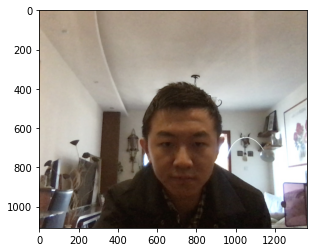

In [18]:
file = 'face1.jpg'
image = Image.open(file)
plt.imshow(image) 

In [12]:
#create image pyramids by scale and the minsize we want to detect faces
#My own work
def MakeGaussianPyramid(image, scale, minsize):
  """
  Arguments:
    image: an PIL.Image
    scale: a float number for each pyramid level scaling
    minsize: The min image size we shrink to, which is relevant to the min size
             of faces we want to detect
  Returns:
    a list of image pyramids 
  """
  img = Image.open(image)
  img = img.resize((640,480))
  img_array = asarray(img, dtype=np.float64)
  x = img_array.shape[1]
  y = img_array.shape[0]
  #minsize = 50 test
  #scale = 0.5 test
  #check how many shrinks do I need
  scale_factor = [1]
  count_x = math.floor(x/minsize)
  count_y = math.floor(y/minsize)
  if (count_x >= count_y):
    count = count_y
  else:
    count = count_x
  L = list([img_array])

  #make sure minsize is not bigger than one shrink
  assert (count != 0), "minsize is too big for the scale"
  if (img_array.ndim == 3):
    for i in range(count):
    #seperate into 3 channels and perform convolution with gaussian filter
      img_array_0 = L[i][:,:,0]
      array_after_0 = gaussian_filter(img_array_0,1/(2*scale))
      img_array_1 = L[i][:,:,1]
      array_after_1 = gaussian_filter(img_array_1,1/(2*scale))
      img_array_2 = L[i][:,:,2]
      array_after_2 = gaussian_filter(img_array_2,1/(2*scale))
      array_after = np.dstack((img_array_0,img_array_1,img_array_2))
      array_re = cv2.resize(array_after,((int(x*(scale)**(i+1)),int(y*(scale)**(i+1)))),interpolation=cv2.INTER_CUBIC)
      index = len(L)
      L.insert(index,array_re)  
      scale_factor.append((scale)**(i+1))
    #for gray scale image
    #gaussian filter first then resize and turn into image format again to add 
    #to the pyramid
  elif (img_array.ndim == 2):
    for i in range(count):
      array_after = gaussian_filter(L[i],1/(2*scale))
      array_re = cv2.resize(array_after,((int(x*(scale)**(i+1)),int(y*(scale)**(i+1)))),interpolation=cv2.INTER_CUBIC)
      #array_re = asarray(img_re)
      index = len(L)
      L.insert(index,array_re)
  print('scale factor:',['{:.2f}'.format(i) for i in scale_factor])
  return(L,scale_factor)


In [13]:
#show the crated image pyramid
#my own work
def ShowGaussianPyramid(pyramid):
  '''
  Arguments:
    A list of image pyramids 
  Returns:
    show the image pyrmaids in the horizontal direction
  '''
  img_array = pyramid
  length = len(pyramid)
  x = 0
  if (pyramid[0].ndim == 2):
    for i in range(length): 
      x += pyramid[i].shape[1]
    image = Image.new("L", (x, pyramid[0].shape[0]),'white')
    x_offset = 0
    for j in range(length):
      img1 = Image.fromarray(img_array[j])
      img_array_1 = img_array[j].copy()
      img_array_1 = img_array_1.astype('uint8')
      img1 = Image.fromarray(img_array_1)
      image.paste(img1,(x_offset,0))
      x_offset += img_array[j].shape[1]
    display(image)
  elif (pyramid[0].ndim == 3):
    for i in range(length): 
      x += pyramid[i].shape[1]
    image = Image.new("RGB", (x, pyramid[0].shape[0]),'white')
    x_offset = 0

    for j in range(length):
      img_array_A = img_array[j]
      img_array_B = img_array_A.astype('uint8')
      img_array_B = np.clip(img_array_B, 0, 255)
      img1 = Image.fromarray(img_array_B)
      #x_offset += img_array[0].shape[1]
      image.paste(img1,(x_offset,0))
      x_offset += img_array[j].shape[1]
    display(image)

scale factor: ['1.00', '0.75', '0.56', '0.42', '0.32', '0.24', '0.18', '0.13', '0.10', '0.08']


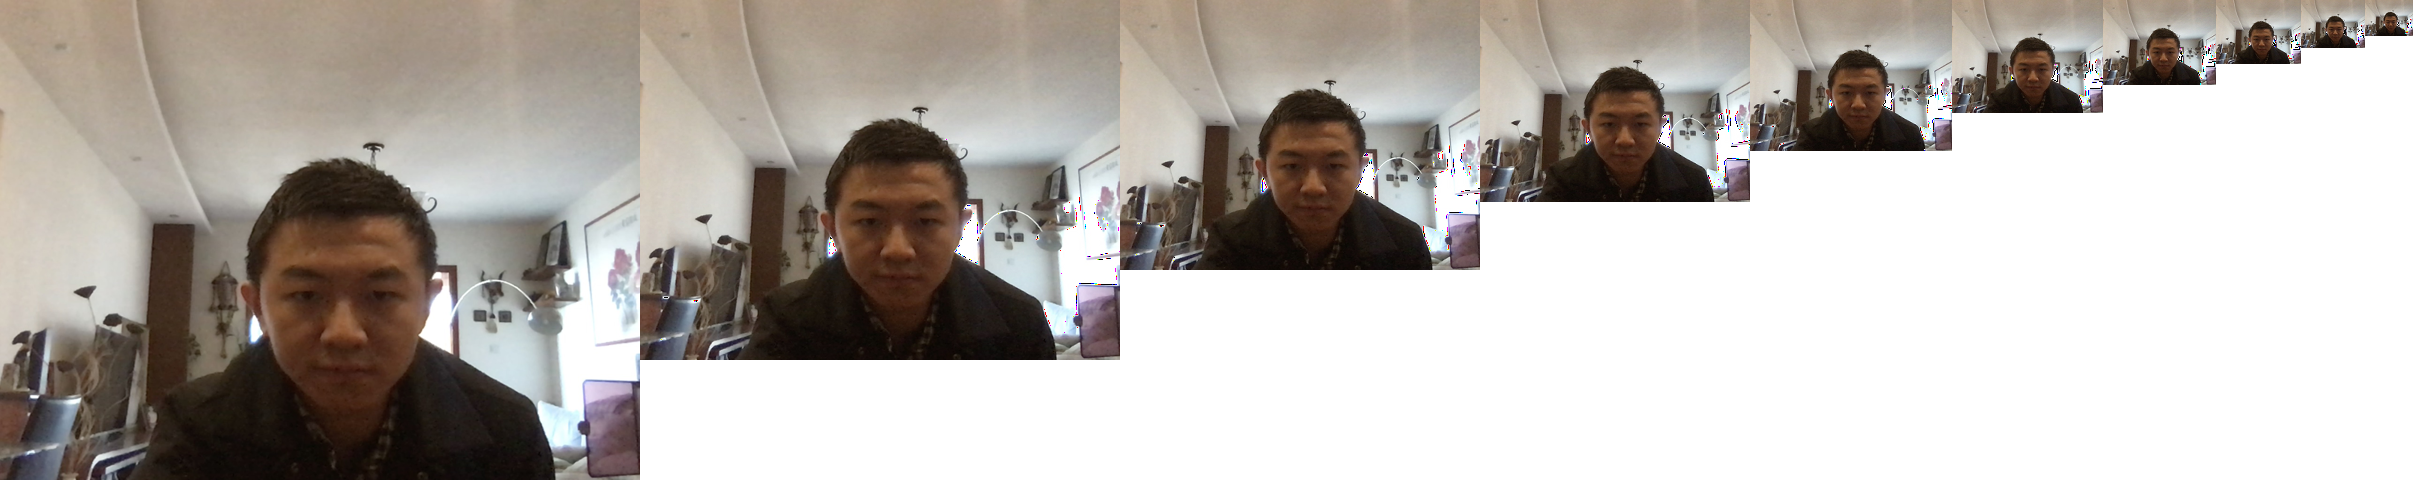

In [14]:
pyramid,scale_factor = MakeGaussianPyramid(file, 0.75, 50)
ShowGaussianPyramid(pyramid)

In [15]:
'''Followed "Joint face Detection and Alignment using multi-task Cscaded Convolutional 
Networks" Structure and tutorial from 
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
Due to the training limitation, used 'pnet.npy' weights from 
https://github.com/TropComplique/mtcnn-pytorch 
'''
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):

        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)

class PNet(nn.Module):

    def __init__(self):

        super(PNet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 10, 3, 1)),
            ('prelu1', nn.PReLU(10)),
            ('pool1', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(10, 16, 3, 1)),
            ('prelu2', nn.PReLU(16)),

            ('conv3', nn.Conv2d(16, 32, 3, 1)),
            ('prelu3', nn.PReLU(32))
        ]))

        self.conv4_1 = nn.Conv2d(32, 2, 1, 1)
        self.conv4_2 = nn.Conv2d(32, 4, 1, 1)

        weights = np.load('src/weights/pnet.npy')[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
      
        x = self.features(x)
        tensor_a = self.conv4_1(x)
        tensor_b = self.conv4_2(x)
        tensor_a = F.softmax(tensor_a)
        return tensor_b, tensor_a

class RNet(nn.Module):

    def __init__(self):

        super(RNet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 28, 3, 1)),
            ('prelu1', nn.PReLU(28)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(28, 48, 3, 1)),
            ('prelu2', nn.PReLU(48)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(48, 64, 2, 1)),
            ('prelu3', nn.PReLU(64)),

            ('flatten', Flatten()),
            ('conv4', nn.Linear(576, 128)),
            ('prelu4', nn.PReLU(128))
        ]))

        self.conv5_1 = nn.Linear(128, 2)
        self.conv5_2 = nn.Linear(128, 4)

        weights = np.load('src/weights/rnet.npy')[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
       
        x = self.features(x)
        tensor_a = self.conv5_1(x)
        tensor_b = self.conv5_2(x)
        tensor_a = F.softmax(tensor_a)
        return tensor_b, tensor_a


class ONet(nn.Module):

    def __init__(self):

        super(ONet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 2, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1152, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        self.conv6_1 = nn.Linear(256, 2)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)

        weights = np.load('src/weights/onet.npy')[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
       
        x = self.features(x)
        tensor_a = self.conv6_1(x)
        tensor_b = self.conv6_2(x)
        tensor_c = self.conv6_3(x)
        tensor_a = F.softmax(tensor_a)
        return tensor_c, tensor_b, tensor_a

In [16]:
'''
Developed by following github https://github.com/TropComplique/mtcnn-pytorch/blob/master/try_mtcnn_step_by_step.ipynb
Integrated with depth input from my own development and tuned parameters used and the overall flow of three stages
'''
def Run_P_Net(pyramid,p_thresholds):
  '''
  Arguments:
    pyramids: A list of image pyramids
    p_thresholds: threshold used for filtering faces after p net prediction
    note that this is a [3,] vector defined previously
  Returns:
    boxes of size (n,5) with 4 box positions and probability 
  '''
  net = PNet()
  boxes = []
  for i in range(len(pyramid)):
    img = pyramid[i]
    #preprocess img and convert to floatTensor format, run though P net to get 
    #probabilities and offsets
    img = Variable(torch.FloatTensor(_preprocess(img)), volatile=True)
    out = net(img)
    probs = out[1].data.numpy()[0, 1, :, :]
    offsets = out[0].data.numpy()
    
    stride = 2
    cell= 15
    # indices of boxes where there is probably a face
    index = np.where(probs > p_thresholds[0])

    # extract parameters from offsets for bounding boxes
    tx1, ty1, tx2, ty2 = [offsets[0, j, index[0], index[1]] for j in range(4)]
    # w = x2 - x1 + 1,h = y2 - y1 + 1,x1 = x1 + tx1*w,x2 = x2 + tx2*w,y1 = y1 + ty1*h,y2 = y2 + ty2*h
    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[index[0], index[1]]

    # P-Net is applied to scaled images
    # rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*index[1] + 1.0)/scale_factor[i]),
        np.round((stride*index[0] + 1.0)/scale_factor[i]),
        np.round((stride*index[1] + 1.0 + cell)/scale_factor[i]),
        np.round((stride*index[0] + 1.0 + cell)/scale_factor[i]),
        score, offsets])
    bounding_boxes = bounding_boxes.T
    #perform nms to merge overlapping boxes
    index1 = nms(bounding_boxes[:, 0:5], overlap_threshold = 0.5)
    boxes.append(bounding_boxes[index1])
  boxes = [i for i in boxes if i is not None]
  boxes = np.vstack(boxes)
  #calibration performed by using offsets predicted from pnet
  boxes = calibrate_box(boxes[:, 0:5], boxes[:, 5:])
  #convert boxes to square
  boxes = convert_to_square(boxes)
  boxes[:, 0:4] = np.round(boxes[:, 0:4])
  print('After P net, number of bounding boxes:', len(boxes))
  return boxes

def Run_R_Net(image,boxes,p_thresholds,nms_thresholds):
  '''
  Arguments:
    image: original image
    boxes: output boxes from the P net (n,5) shape
    p_thresholds: threshold used for filtering faces after n net prediction
    note that this is a [3,] vector defined previously
    nms_thresholds: threshold used for filtering faces after n net prediction
    note that this is a [3,] vector defined previously
  Returns:
    boxes: boudning boxes of size (n,5) with 4 box positions and probability
  '''
  net = RNet()
  boxes_R = get_image_boxes(boxes, image, size=24)

  #convert to floatTensor format, run though R net to get 
  #probabilities and offsets
  boxes_R = Variable(torch.FloatTensor(boxes_R), volatile=True)
  out = net(boxes_R)
  probs = out[1].data.numpy()
  offsets = out[0].data.numpy()
  # indices of boxes where there is probably a face
  index = np.where(probs[:, 1] > p_thresholds[1])[0]
  boxes = boxes[index]
  boxes[:, 4] = probs[index, 1].reshape((-1,))
  offsets = offsets[index]
  #NMS and calibration
  index1 = nms(boxes, nms_thresholds[1])
  boxes = boxes[index1]
  boxes = calibrate_box(boxes, offsets[index1])
  boxes = convert_to_square(boxes)
  boxes[:, 0:4] = np.round(boxes[:, 0:4])
  print('After R net, number of bounding boxes:', len(boxes))
  return boxes
  
def Run_O_Net(image,boxes,p_thresholds,nms_thresholds):
  '''
  Arguments:
    image: original image
    boxes: output boxes from the P net (n,5) shape
    p_thresholds: threshold used for filtering faces after n net prediction
    note that this is a [3,] vector defined previously
    nms_thresholds: threshold used for filtering faces after n net prediction
    note that this is a [3,] vector defined previously
  Returns:
    boxes: boudning boxes of size (n,5) with 4 box positions and probability
    landmarks: facial landmarks of size (n,10) 
  '''
  net = ONet()
  boxes_O = get_image_boxes(boxes, image, size=48)
  boxes_O = Variable(torch.FloatTensor(boxes_O), volatile=True)
  out = net(boxes_O)
  landmarks = out[0].data.numpy()  # shape [n_boxes, 10]
  offsets = out[1].data.numpy()  # shape [n_boxes, 4]
  probs = out[2].data.numpy()  # shape [n_boxes, 2]
  #indices of boxes where there is probably a face. In addtional to P,R , O net
  #outputs facial landmarks
  index = np.where(probs[:, 1] > p_thresholds[2])[0]
  boxes = boxes[index]
  boxes[:, 4] = probs[index, 1].reshape((-1,))
  offsets = offsets[index]
  landmarks = landmarks[index]
  #Extract landmark information based on boxes size
  w = boxes[:, 2] - boxes[:, 0] + 1.0
  h = boxes[:, 3] - boxes[:, 1] + 1.0
  xmin, ymin = boxes[:, 0], boxes[:, 1]
  landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(w, 1)*landmarks[:, 0:5]
  landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(h, 1)*landmarks[:, 5:10]
  #NMS and calibration
  boxes = calibrate_box(boxes, offsets)
  index1 = nms(boxes, nms_thresholds[2], mode='min')
  boxes = boxes[index1]
  landmarks = landmarks[index1]
  print('After O net, number of bounding boxes:', len(boxes))
  return boxes, landmarks

scale factor: ['1.00', '0.75', '0.56', '0.42', '0.32', '0.24', '0.18', '0.13', '0.10', '0.08']


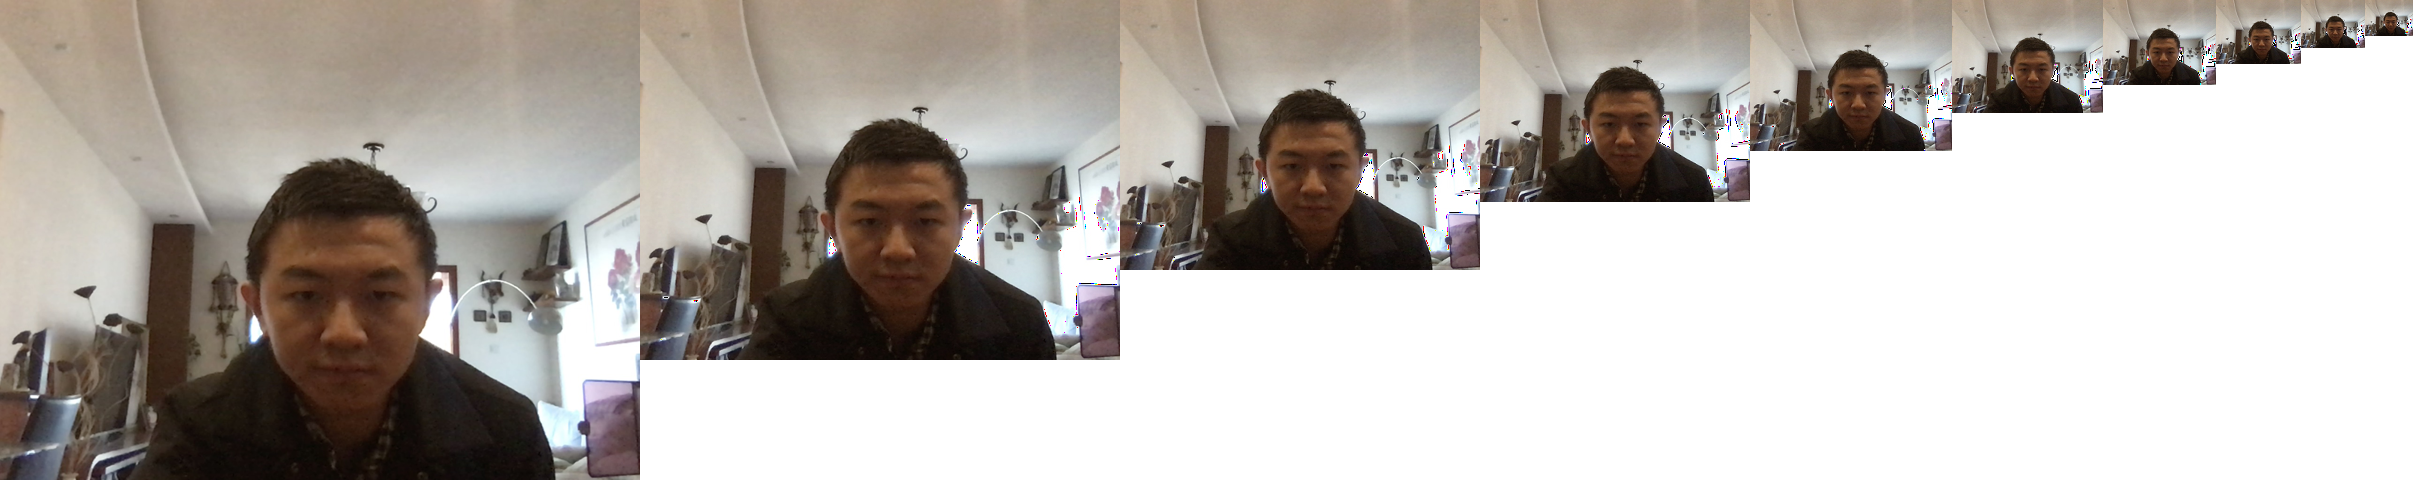

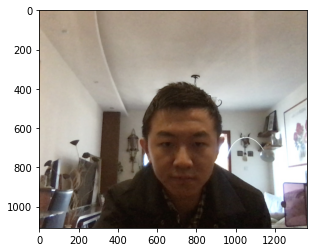

In [23]:
file = 'face1.jpg'
image = Image.open(file)
plt.imshow(image) 
pyramid,scale_factor = MakeGaussianPyramid(file, 0.75, 50)
ShowGaussianPyramid(pyramid)

In [24]:
boxes_P = Run_P_Net(pyramid,p_thresholds)
boxes_R = Run_R_Net(image,boxes_P,p_thresholds,nms_thresholds)
boxes_O,landmarks = Run_O_Net(image,boxes_R,p_thresholds,nms_thresholds)
show_bboxes(image, boxes_O, landmarks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


After P net, number of bounding boxes: 160
After R net, number of bounding boxes: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


RuntimeError: ignored